## 1. Data Acquisition and Preparation

In [2]:
import math
import functools
import numpy as np
import pandas as pd
import yfinance as yf
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.manifold import TSNE

### 1.1 Define Asset Universe
Create a diverse universe.

In [4]:
tickers = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "JPM", "BAC", "JNJ", "WMT", "XOM",  # U.S. Equities
    "EFA", "EEM",  # International Equities
    "TLT",        # Fixed Income
    "GLD"         # Commodities
]
data = yf.download(tickers, start = "2018-01-01", end = "2025-06-25", auto_adjust = False)

# Display the downloaded data.
data

[*********************100%***********************]  13 of 13 completed


Price        Adj Close                                               \
Ticker            AAPL        AMZN        BAC        EEM        EFA   
Date                                                                  
2018-01-02   40.426823   59.450500  25.044060  40.555489  56.610878   
2018-01-03   40.419785   60.209999  24.960304  40.944073  56.882622   
2018-01-04   40.607529   60.479500  25.286968  41.146801  57.506042   
2018-01-05   41.069870   61.457001  25.404234  41.501595  57.825737   
2018-01-08   40.917309   62.343498  25.228334  41.501595  57.809753   
...                ...         ...        ...        ...        ...   
2025-06-17  195.639999  214.820007  44.230000  46.610001  86.959999   
2025-06-18  196.580002  212.520004  45.060001  46.599998  87.110001   
2025-06-20  201.000000  209.690002  45.500000  46.330002  86.330002   
2025-06-23  201.500000  208.470001  46.299999  46.709999  86.980003   
2025-06-24  200.300003  212.770004  46.660000  47.919998  88.040001   

Price                                                                   ...  \
Ticker             GLD       GOOGL         JNJ         JPM        MSFT  ...   
Date                                                                    ...   
2018-01-02  125.150002   53.340595  112.882545   87.152023   79.328506  ...   
2018-01-03  124.820000   54.250641  113.960838   87.240822   79.697685  ...   
2018-01-04  125.459999   54.461376  113.952774   88.490608   80.399155  ...   
2018-01-05  125.330002   55.183544  114.893234   87.922516   81.395973  ...   
2018-01-08  125.309998   55.378376  115.039162   88.052361   81.479027  ...   
...                ...         ...         ...         ...         ...  ...   
2025-06-17  311.940002  175.949997  152.380005  268.227753  478.040009  ...   
2025-06-18  310.260010  173.320007  150.729996  272.646484  480.239990  ...   
2025-06-20  310.130005  166.639999  149.789993  273.681488  477.399994  ...   
2025-06-23  311.079987  165.190002  151.320007  276.935822  486.000000  ...   
2025-06-24  306.190002  166.770004  152.190002  279.911499  490.109985  ...   

Price         Volume                                                    \
Ticker           EEM       EFA       GLD     GOOGL       JNJ       JPM   
Date                                                                     
2018-01-02  68969400  26530000  11762500  31766000   6842100  13578800   
2018-01-03  56228700  33384900   7904300  31318000   5350500  11901000   
2018-01-04  52154900  23974400   7329700  26052000   4837600  12953700   
2018-01-05  50026900  17483800   5739900  30250000   6158800  14155000   
2018-01-08  36998200  21733700   3566700  24644000   5129800  12466500   
...              ...       ...       ...       ...       ...       ...   
2025-06-17  35176900  16726300   8234100  24973000   6407100   6739300   
2025-06-18  26286900  18504400   9370800  28707500   8325200   9586400   
2025-06-20  32783300  16900600   8794700  75659900  22605500  13969700   
2025-06-23  22233200  23100600  12687900  57671000   7397900   8094600   
2025-06-24  36113900  14900600  12035200  40524300   9544200   9267900   

Price                                               
Ticker          MSFT       TLT       WMT       XOM  
Date                                                
2018-01-02  22483800  16238200  30451500  11469300  
2018-01-03  26061400   8605100  26710800  13957700  
2018-01-04  21912000   9217900  20491200  10863000  
2018-01-05  23407100  10915400  21852000  11047600  
2018-01-08  22113000   8850600  26531700  10927100  
...              ...       ...       ...       ...  
2025-06-17  15414100  34521600  14935600  19451700  
2025-06-18  17526500  38589000  11333700  17968900  
2025-06-20  37576200  26001900  20604900  36273300  
2025-06-23  24864000  36851800  20432400  26631100  
2025-06-24  22305600  32959100  22403700  24828300  

[1879 rows x 78 columns]

In [5]:
data.to_csv("BL_proj_stocks.csv", index = False)

## 2. Feature Engineering

Compute factros :

- Momentum :
    Calculate momentum as the percentage change over a specified window.
- Volatility :
    Compute rolling volatility using the standard deviation of daily returns (which approximate log daily returns).
- Average Volume :
    Determine the rolling average volume over the lookback period.


As I am going to build a dynamic portfolio, I define also lookback period and rebalance period.

In [7]:
lookback = 126
rebalance_period = 21

adj_close = data["Adj Close"].dropna()
daily_returns = adj_close.pct_change().dropna()

momentum = (adj_close / adj_close.shift(21) -1).dropna()
volatility = (np.log(1 + daily_returns)).rolling(lookback).std().dropna()
avgvolume = data["Volume"].rolling(lookback).mean().dropna()

factors_df = pd.DataFrame({})

for ticker in tickers :
    factors_df[f"Momentum_{ticker}"] = momentum[ticker]
    factors_df[f"Volatility_{ticker}"] = volatility[ticker]
    factors_df[f"AvgVolume_{ticker}"] = avgvolume[ticker]
    
factors_df.dropna(how = "any")

,Momentum_AAPL,Volatility_AAPL,AvgVolume_AAPL,Momentum_MSFT,Volatility_MSFT,AvgVolume_MSFT,Momentum_AMZN,Volatility_AMZN,AvgVolume_AMZN,Momentum_GOOGL,...,AvgVolume_EFA,Momentum_EEM,Volatility_EEM,AvgVolume_EEM,Momentum_TLT,Volatility_TLT,AvgVolume_TLT,Momentum_GLD,Volatility_GLD,AvgVolume_GLD
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-03,-0.041234,0.015174,1.308631e+08,-0.025770,0.016675,3.049652e+07,0.017228,0.017895,1.039207e+08,-0.031881,...,2.655972e+07,-0.076700,0.013021,7.215175e+07,0.023832,0.006128,8.977711e+06,-0.030400,0.006081,7.402794e+06
2018-07-05,-0.040919,0.015188,1.304531e+08,-0.023779,0.016681,3.044030e+07,0.001993,0.017873,1.039007e+08,-0.008453,...,2.644233e+07,-0.071926,0.012989,7.224037e+07,0.024367,0.006118,8.940055e+06,-0.030932,0.006087,7.379362e+06
2018-07-06,-0.030982,0.015229,1.302960e+08,-0.012977,0.016706,3.041905e+07,0.008775,0.017875,1.038417e+08,0.007088,...,2.638413e+07,-0.073110,0.013044,7.238147e+07,0.036112,0.006126,8.904039e+06,-0.033030,0.006068,7.344578e+06
2018-07-09,-0.014887,0.015244,1.301721e+08,0.009616,0.016684,3.037782e+07,0.029432,0.017878,1.037571e+08,0.028966,...,2.640951e+07,-0.041820,0.013123,7.262374e+07,0.019569,0.006147,8.864652e+06,-0.030197,0.006073,7.331363e+06
2018-07-10,-0.007042,0.015240,1.300251e+08,0.004822,0.016685,3.035544e+07,0.035083,0.017848,1.035545e+08,0.030396,...,2.638767e+07,-0.042132,0.013123,7.283652e+07,0.022556,0.006147,8.840121e+06,-0.033168,0.006075,7.332856e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17,-0.073937,0.025217,5.700793e+07,0.052326,0.018578,2.286448e+07,0.044895,0.023821,4.350387e+07,0.060010,...,1.506900e+07,0.017327,0.013243,2.660618e+07,0.006049,0.009011,3.973066e+07,0.060155,0.012411,1.012725e+07
2025-06-18,-0.058435,0.025223,5.710507e+07,0.046571,0.018574,2.284344e+07,0.030850,0.023832,4.362762e+07,0.041971,...,1.513557e+07,0.014915,0.013243,2.666099e+07,0.010721,0.008967,3.972354e+07,0.041036,0.012364,1.014922e+07
2025-06-20,-0.028328,0.025286,5.746315e+07,0.041971,0.018565,2.295437e+07,0.027540,0.023759,4.392760e+07,0.017452,...,1.506694e+07,0.010124,0.013244,2.666514e+07,0.016177,0.008964,3.974354e+07,0.021576,0.012366,1.019274e+07


## 3. Exploratory Data Analysis

### 3.1 Correlation Matrix

Visualize the correlation between computed factors and daily returns.

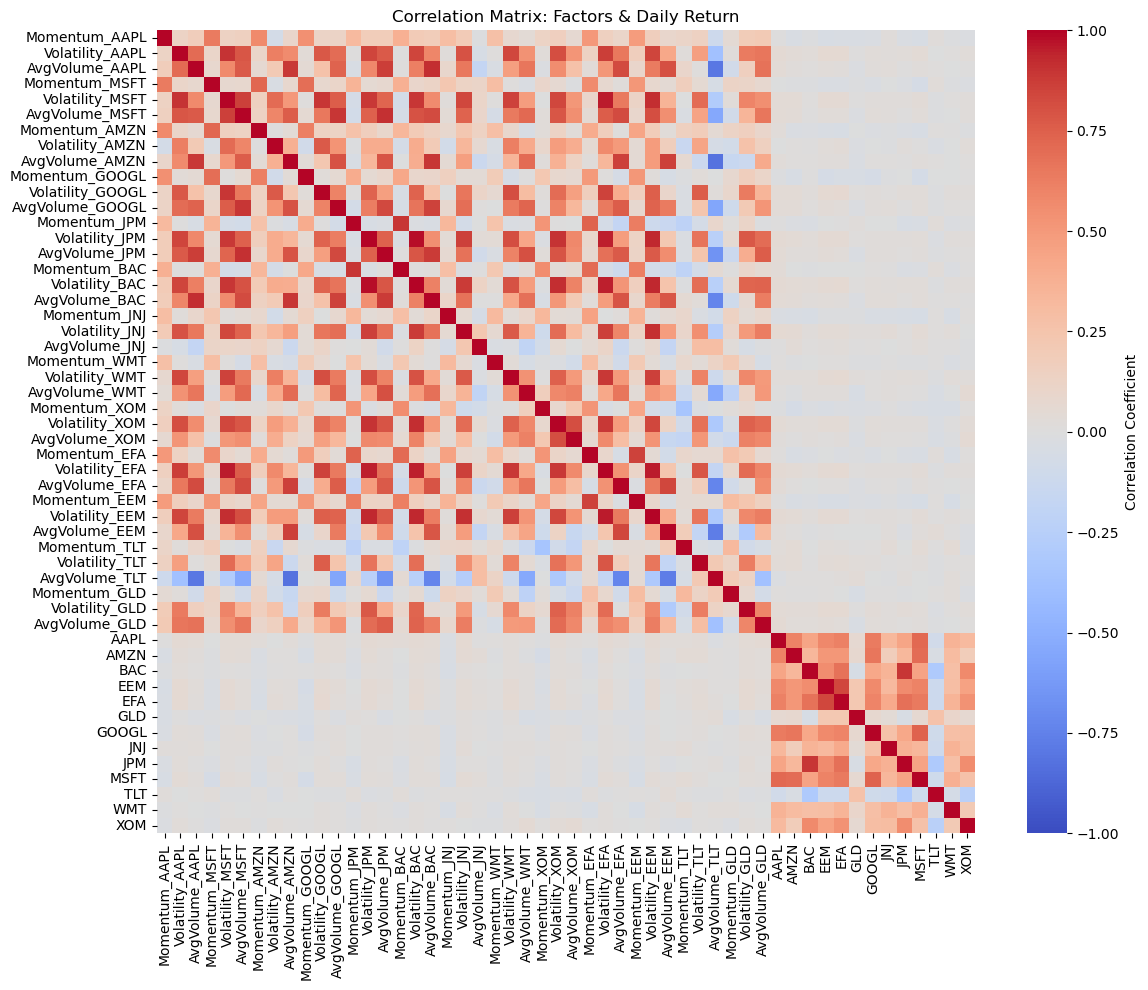

In [10]:
shifted_factors = factors_df.shift(1)
factors_return_corr = pd.concat([shifted_factors, daily_returns], axis = 1).corr()

plt.figure(figsize = (12, 10))
sns.heatmap(
    factors_return_corr,
    annot = False,
    vmin = -1, vmax = 1,
    cmap = "coolwarm",
    cbar_kws = {"label": "Correlation Coefficient"}
)
plt.title("Correlation Matrix: Factors & Daily Return")
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

### 3.2 Histograms

Plot histograms to explore the distribution of daily returns for each asset.

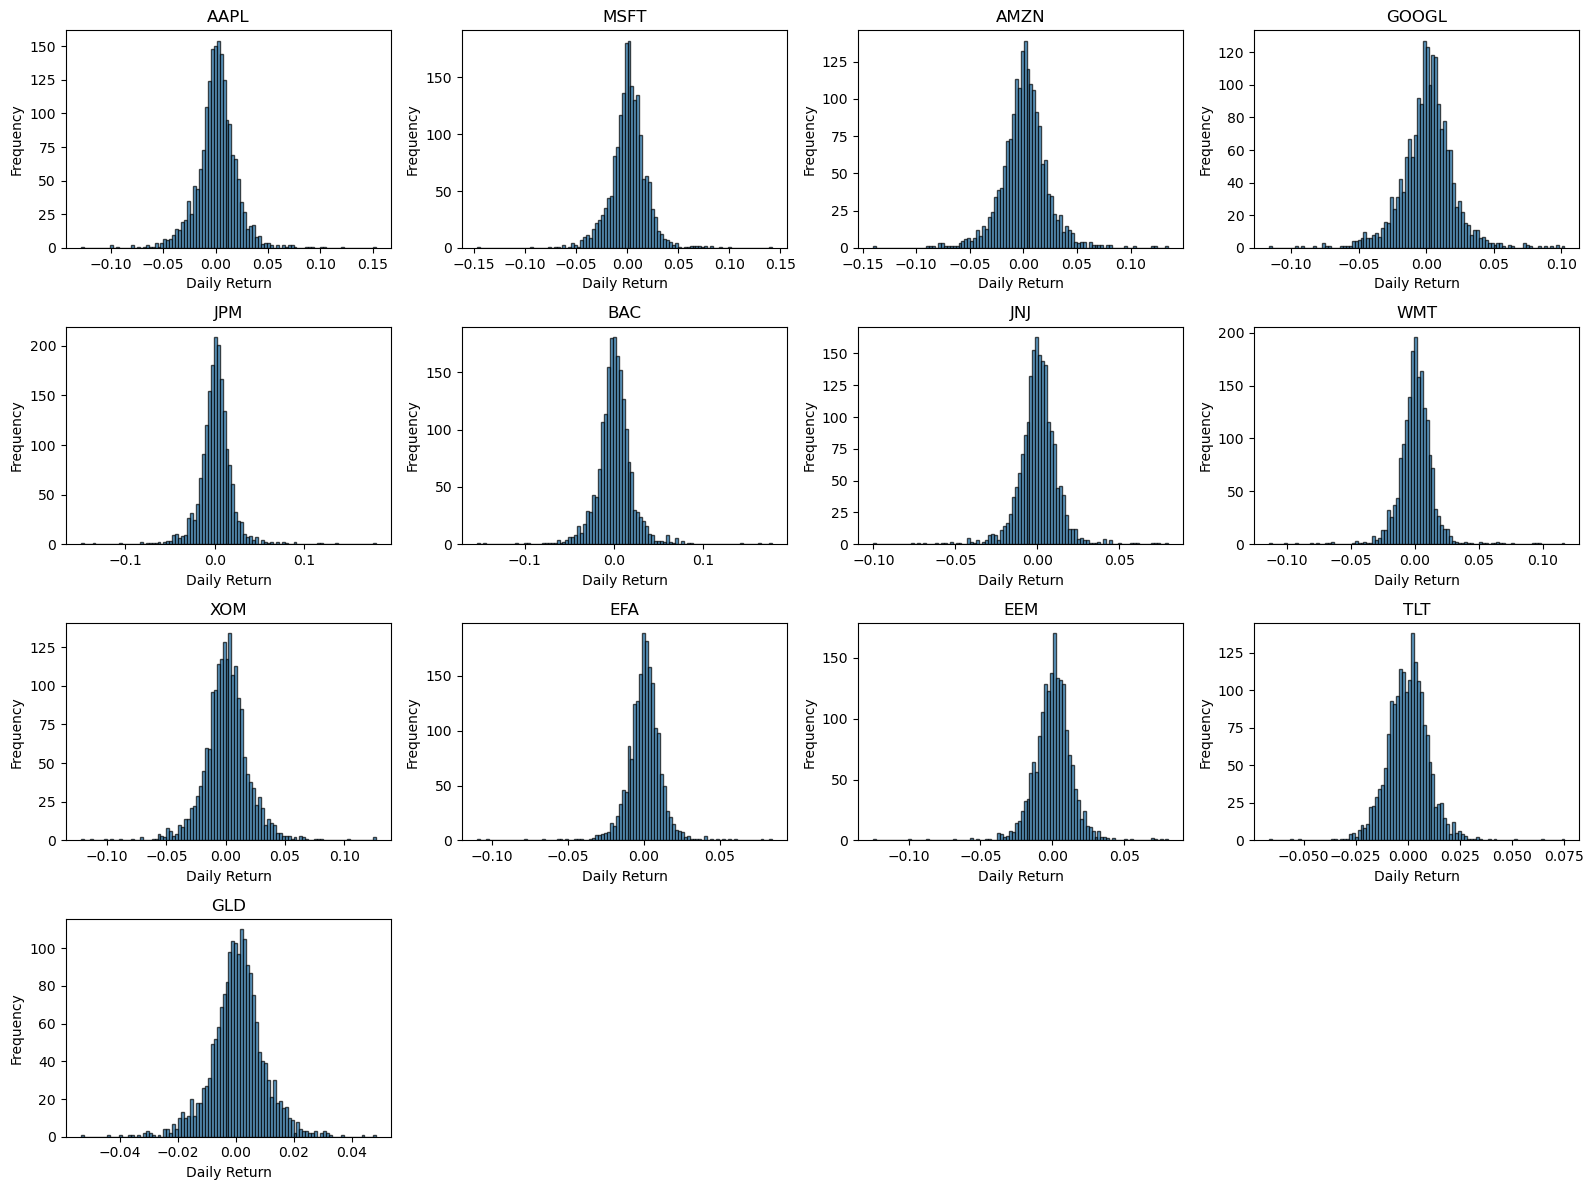

In [12]:
n_cols = 4
n_tickers = len(tickers)
n_rows = (n_tickers + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex = False, sharey = False)
axes = axes.flatten()

for ax, ticker in zip(axes, tickers):
    ax.hist(daily_returns[ticker], bins = 100, edgecolor = "k", alpha = 0.7)
    ax.set_title(ticker)
    ax.set_xlabel("Daily Return")
    ax.set_ylabel("Frequency")

# Turn off any unused subplots
for ax in axes[n_tickers:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

### 3.3 Scatter Plots

Examine the relationship between each factor (momentum, volatility, average volume) and the respective asset returns, identifying outliers or patterns.

We can see many outliers and high-leverage points.

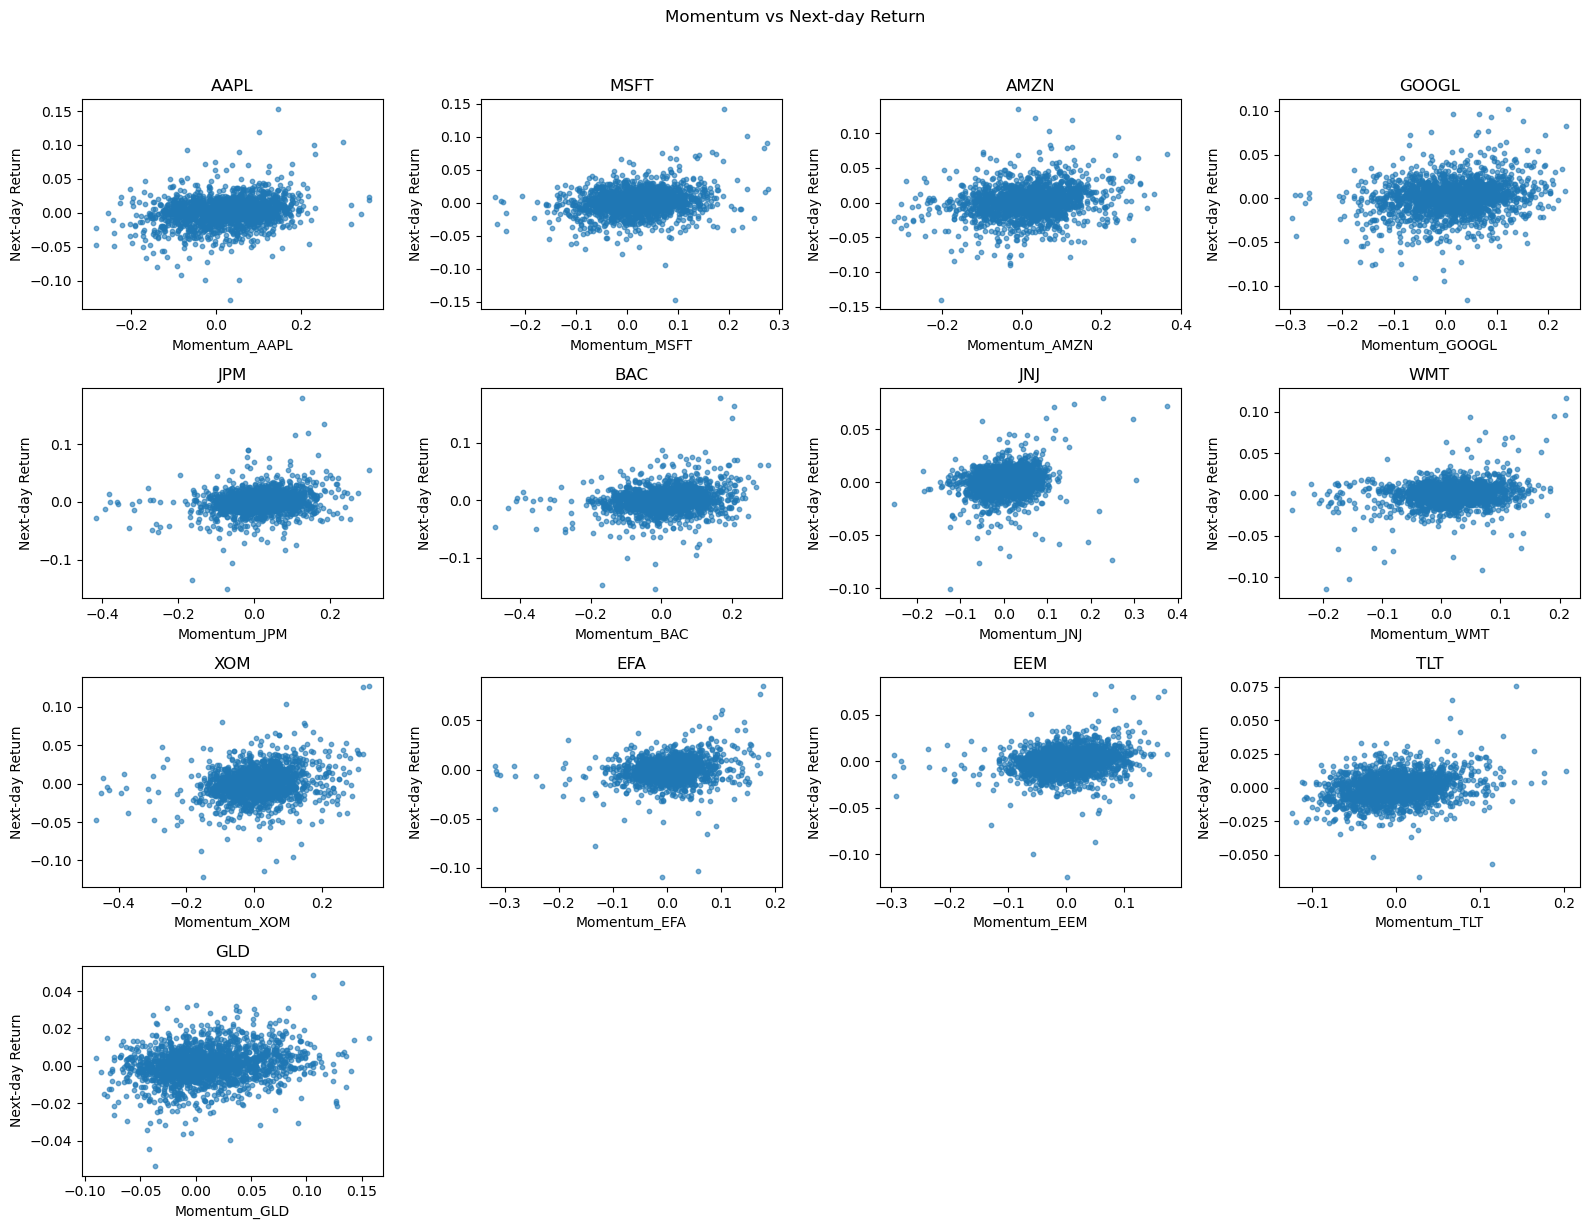

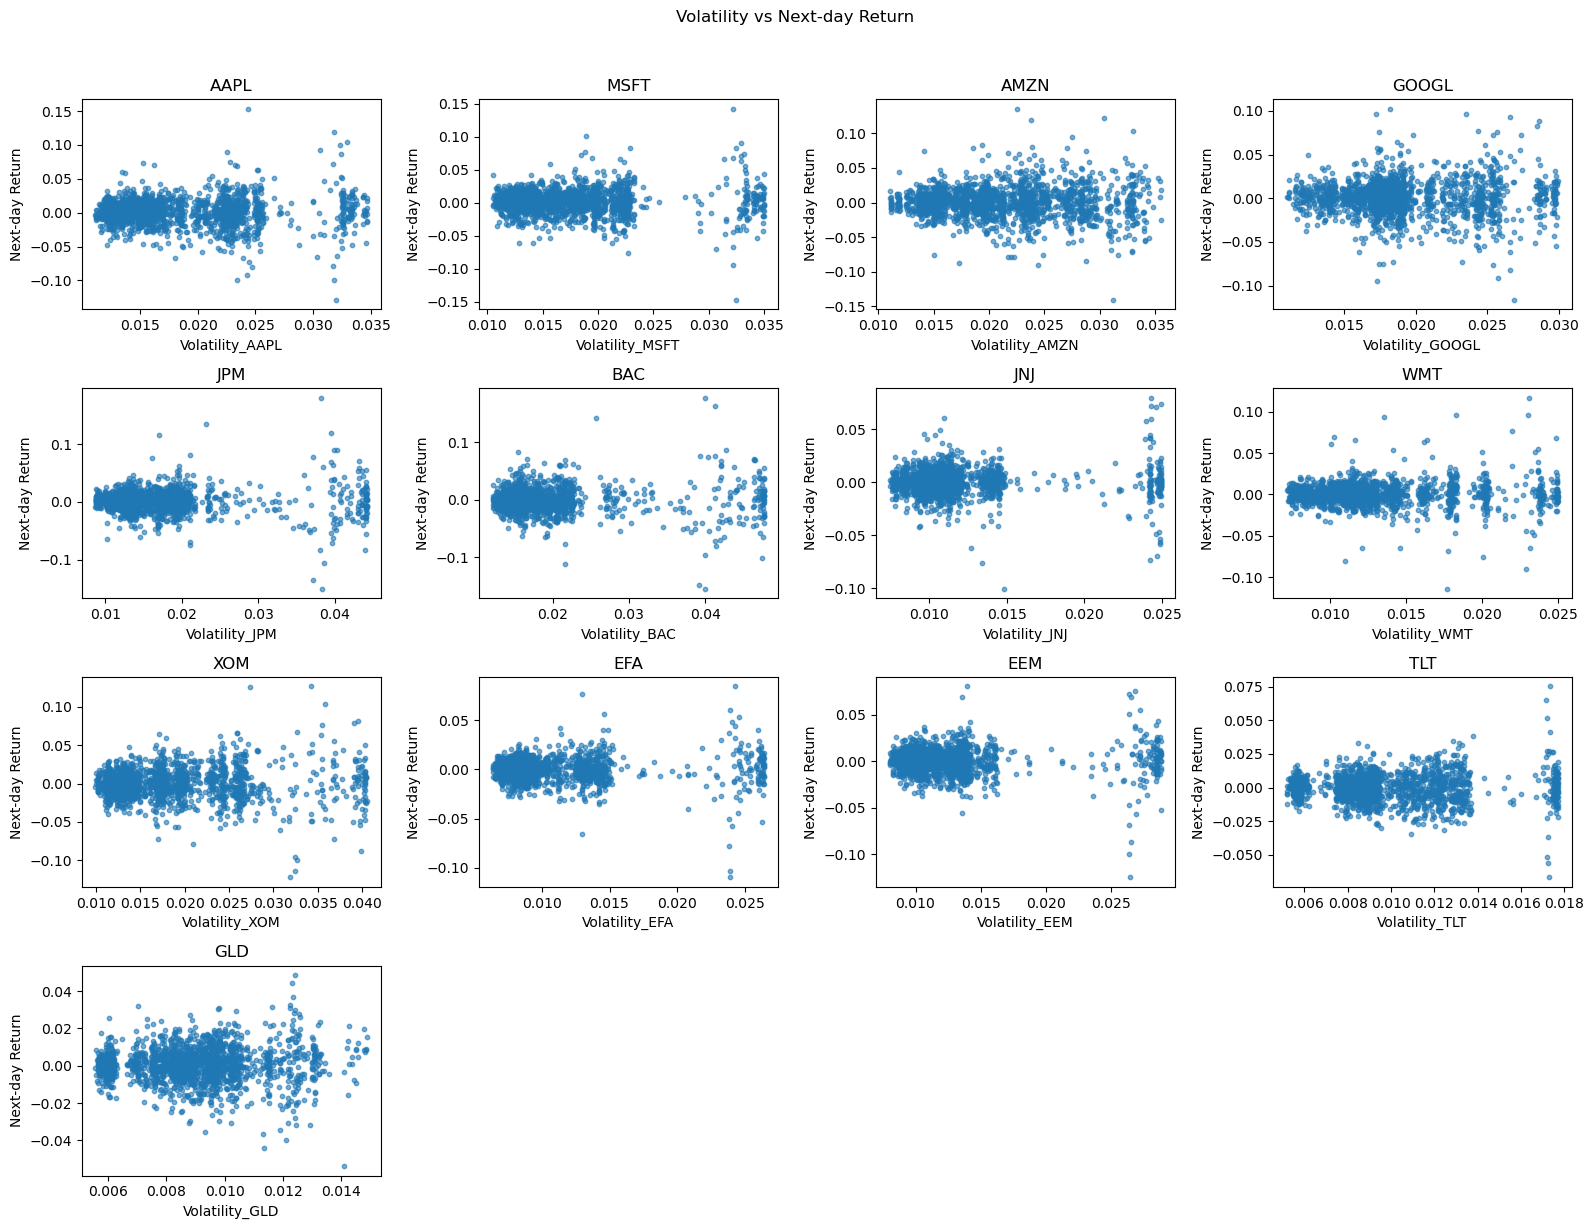

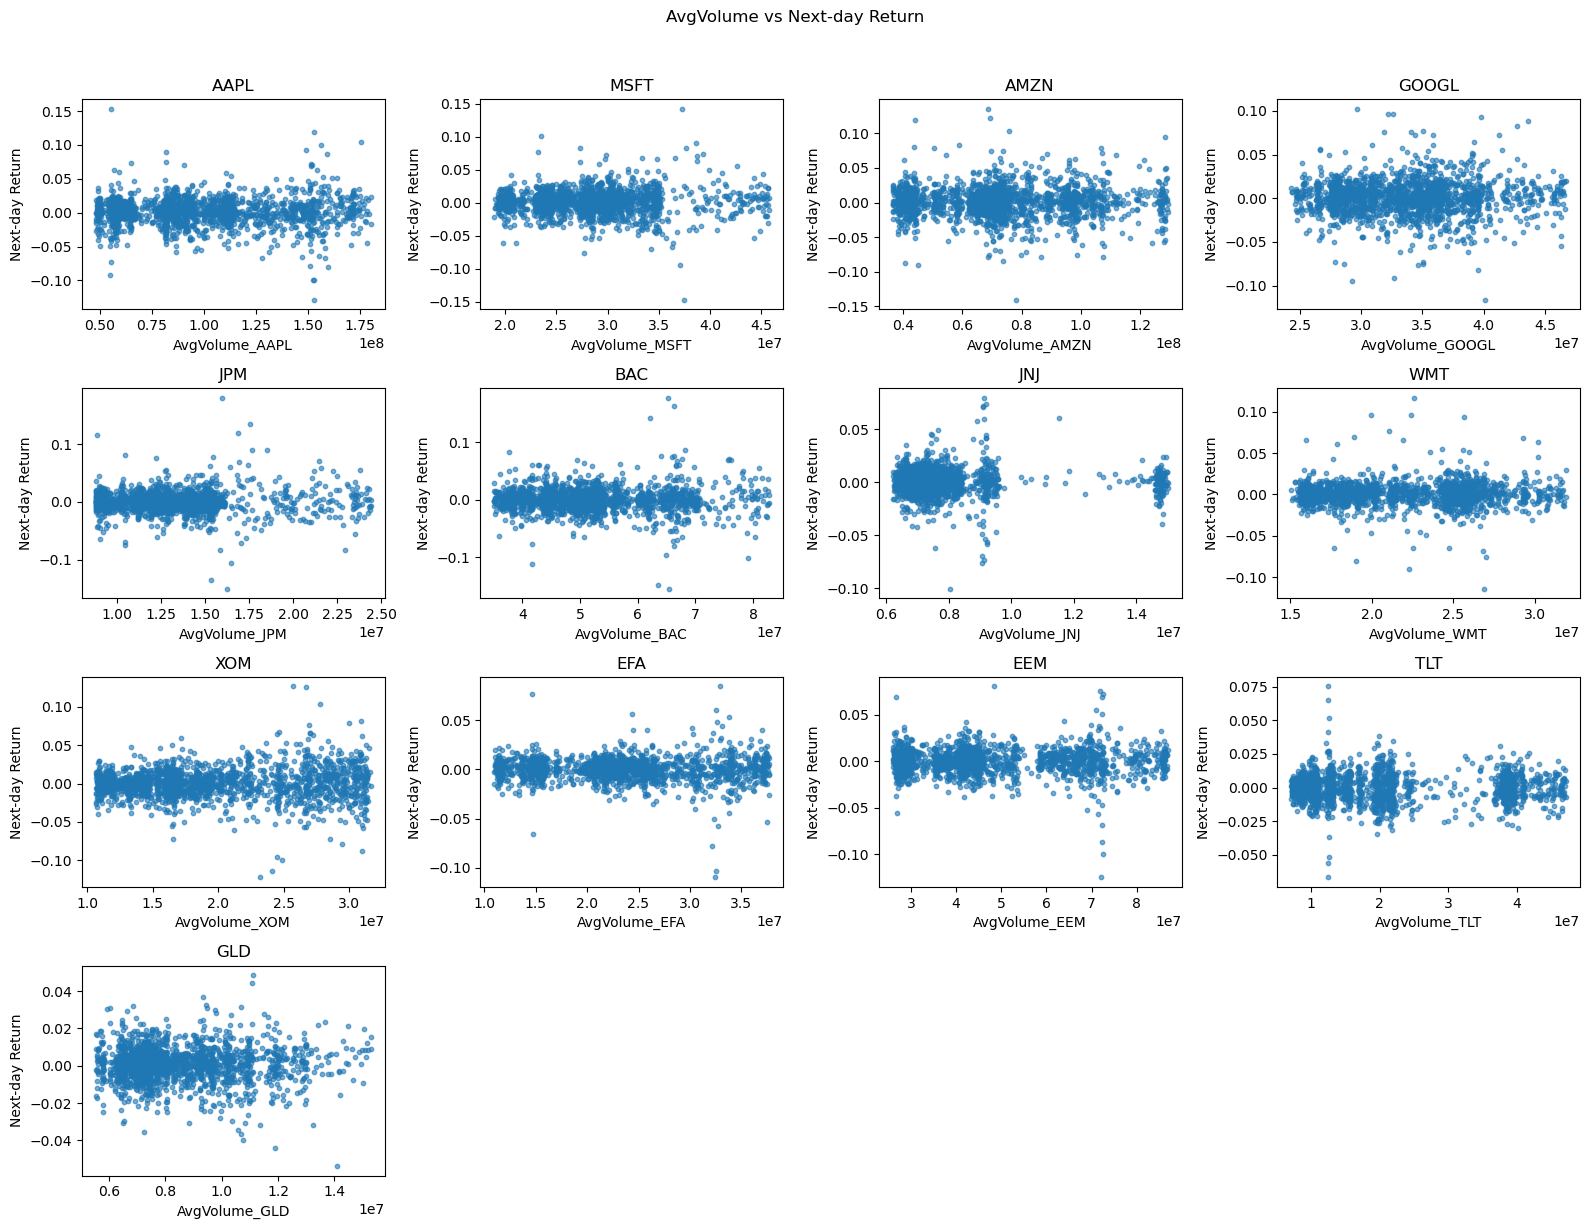

In [14]:
rebalance_shift = rebalance_period - 1
n_cols = 4

for factor in ["Momentum", "Volatility", "AvgVolume"]:
    n_tickers = len(tickers)
    n_rows = int(np.ceil(n_tickers / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    axes = axes.flatten()

    for ax, ticker in zip(axes, tickers):
        x = factors_df[f"{factor}_{ticker}"]
        y = daily_returns[ticker].shift(rebalance_shift)
        common = x.index.intersection(y.dropna().index)
        ax.scatter(x.loc[common], y.loc[common], alpha = 0.6, s = 10)
        ax.set_title(ticker)
        ax.set_xlabel(f"{factor}_{ticker}")
        ax.set_ylabel("Next-day Return")

    # Turn off unused axes
    for ax in axes[n_tickers:]:
        ax.axis("off")

    plt.suptitle(f"{factor} vs Next-day Return", y = 1.02)
    plt.tight_layout()
    plt.show()

### 3.4 t-SNE Embedding of Stocks by Daily Return Profiles

This code block performs a t-SNE dimensionality reduction on stock return and visualizes the resulting 2D embedding.

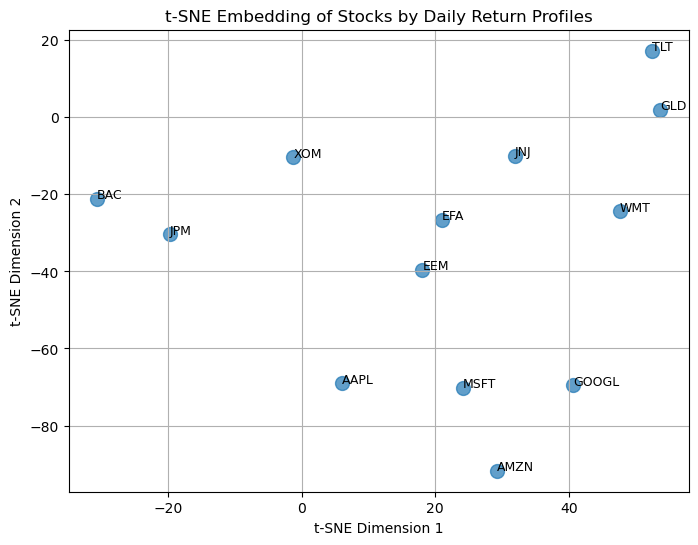

In [16]:
# Prepare asset-return matrix: rows = tickers, cols = dates
R = daily_returns.T.fillna(0).values  # shape: (n_assets, n_days)
tickers_list = daily_returns.columns.tolist()

tsne = TSNE(n_components = 2, random_state = 42, perplexity = 5)
coords = tsne.fit_transform(R)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(coords[:, 0], coords[:, 1], s = 100, alpha = 0.7)
for i, ticker in enumerate(tickers_list):
    plt.text(coords[i, 0], coords[i, 1], ticker, fontsize = 9)
plt.title("t-SNE Embedding of Stocks by Daily Return Profiles")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

### 4. Machine Learning-Based Return Forecasting

### 4.1 XGBoost Model

In [19]:
def train_predict_xgboost(feature_df, target_series):
    X_train = feature_df.iloc[:-1]
    y_train = target_series.iloc[:-1]
    X_current = feature_df.iloc[[-1]]
    
    model_xgb = xgb.XGBRegressor(objective = "reg:squarederror", n_estimators = 10, random_state = 42)
    model_xgb.fit(X_train, y_train)
    prediction = model_xgb.predict(X_current)[0]
    return prediction

## 5. Constructing Investor Views via Black-Litterman Framework

### 5.1 Compute $\Omega$ 

Calculate the view uncertainty (diagonal matrix) as $\Omega = diag(\tau \times P_i \times \Sigma \times P_i^T$) for each view row $i$ in $P$.

In [22]:
def compute_Omega(P, Sigma, tau):
    omega_diag = []
    for i in range(P.shape[0]):
        P_i = P[i, :]
        var_view = tau * (P_i @ Sigma @ P_i.T)
        omega_diag.append(var_view)
    return np.diag(omega_diag)

### 5.2 Compute $\mu_{BL}$ 

Compute Black-Litterman adjusted expected returns as 
$$
\mu_{BL} = \left[ (\tau \Sigma)^{-1} + P^T \Omega^{-1} P \right]^{-1} \left[ (\tau \Sigma)^{-1} \pi + P^T \Omega^{-1} Q \right]
$$

In [78]:
PERTURB_Q = False

def compute_mu_BL(pi, Sigma, P, Q, tau, Omega):
    """
    Compute Black-Litterman adjusted expected returns, optionally
    perturbing Q by \\epsilon ~ N(0, \\Omega_ii) when PERTURB_Q is True.
    """
    global PERTURB_Q
    
    # If flag is set, add elementwise noise to Q
    if PERTURB_Q:
        eps = np.random.normal(
            loc=0.0,
            scale=np.sqrt(np.diag(Omega)),
            size=Q.shape
        )
        Q = Q + eps

    inv_tauSigma = np.linalg.inv(tau * Sigma)
    inv_Omega    = np.linalg.inv(Omega)
    A = inv_tauSigma + P.T @ inv_Omega @ P
    B = inv_tauSigma @ pi      + P.T @ inv_Omega @ Q
    mu_BL = np.linalg.inv(A) @ B
    return mu_BL

### 5.3 Rule-based signal 

Construct a rule-based signal $Q_{rule}$, which will be used later to adjust $Q$ : For each asset, compare its AvgVolume with every other asset. 
If AvgVolume(asset) > AvgVolume(other), asset gets an advantage of (AvgVolume(asset)/AvgVolume(other)-1).

In [26]:
def rule_based_view(avgvol_series):
    tickers_local = avgvol_series.index.tolist()
    signals = {}
    for asset in tickers_local:
        advantages = []
        for other in tickers_local:
            if asset == other:
                continue
            if avgvol_series.loc[asset] > avgvol_series.loc[other]:
                advantages.append(avgvol_series.loc[asset] / avgvol_series.loc[other] - 1)
        signals[asset] = np.mean(advantages) if advantages else 0.0
    return pd.Series(signals)

## 5.4 Generate Views

**Assumption**: $P$ is the identity matrix for simplicity.

To compute the final view vector $Q$ at each rebalance:

1. **Machine Learning–Based Views** ($Q_{ml}$)  
   Use historical features (momentum, volatility, avg-volume) with an XGBoost regressor to predict each asset's forward return.

2. **Rule-Based Views** ($Q_{rule}$)  
   For each asset $i$, compare its avg-volume $v_i$ to every other $v_j$.  
   $$
     Q_{rule,i}
     = \frac{1}{N-1}\sum_{j\neq i}\Bigl(\tfrac{v_i}{v_j}-1\Bigr).
   $$

3. **Normalize & Weight**  
   Over the lookback window, z-score each view series:  
   $$
     Q^z_{ml,i} = \frac{Q_{ml,i}-\mu_{ml}}{\sigma_{ml}},\quad
     Q^z_{rule,i} = \frac{Q_{rule,i}-\mu_{rule}}{\sigma_{rule}}.
   $$  
   Compute in-sample MAE over the last $K = 5$ (error_window) rebalances for each signal against the **realized forward return**  
   $Q^{(t)}_{\text{true},i}$ (i.e.\ the actual portfolio excess return of asset $i$ from rebalance $t$ to $t+1$):  
   $$
     \mathrm{MAE}_{ml,i}
     = \frac{1}{K}\sum_{s=t-K+1}^t\bigl|Q^{(s)}_{ml,i}-Q^{(s)}_{\text{true},i}\bigr|,\quad
     \mathrm{MAE}_{rule,i}
     = \frac{1}{K}\sum_{s=t-K+1}^t\bigl|Q^{(s)}_{\text{rule},i}-Q^{(s)}_{\text{true},i}\bigr|.
   $$  
   Then  
   $$
     w_{ml,i}
     = \frac{1/\mathrm{MAE}_{ml,i}}{1/\mathrm{MAE}_{ml,i} + 1/\mathrm{MAE}_{rule,i}},\quad
     w_{rule,i} = 1 - w_{ml,i},
   $$  
   and  
   $$
     Q_{\text{comb},i} = w_{ml,i}\,Q^z_{ml,i} + w_{rule,i}\,Q^z_{rule,i}.
   $$

4. **Define and Smooth Alpha**  
   - Let $\alpha_t$ be the **realized annualized alpha** of our portfolio between rebalance $t-1$ and $t$ (computed by regressing portfolio excess returns on benchmark excess returns).  
   - Smooth $\alpha_t$ with an EWMA (with $\lambda = 0.9$):  
     $$
       \bar\alpha_t
       = \lambda\,\bar\alpha_{t-1} + (1-\lambda)\,\alpha_t,
       \quad\bar\alpha_0=\alpha_0.
     $$  
     Here $\bar\alpha_t$ is the **smoothed alpha** at rebalance $t$.

5. **Calibrate Adjustment Factors**  
   Split the history of rebalance dates into train/test (70%/30%):

   - On the train set, search for up/down multipliers $(u,d)$ (we impose the constraints $1.0\leq u\leq 5.0$ and $0.1\leq d\leq 1.0$) that maximize average $\bar\alpha_t$.

7. **Final $Q$ Adjustment**  
   Compute the change $\Delta\bar\alpha = \bar\alpha_t - \bar\alpha_{t-1}$. Then  
   $$
     Q_i =
     \begin{cases}
       u\,e^{\Delta\bar\alpha}\;Q_{\text{comb},i}, & \Delta\bar\alpha>0,\\
       d\,e^{\Delta\bar\alpha}\;Q_{\text{comb},i}, & \Delta\bar\alpha<0,\\
       Q_{\text{comb},i}, & \Delta\bar\alpha=0.
     \end{cases}
   $$  
   Here $u$ and $d$ are the calibrated “risk-aversion” factors.


In [28]:
# === Helpers ===
def _zscore(series, lookback):
    return (series - series.rolling(lookback).mean()) / series.rolling(lookback).std()

def _combine_Q(Q_ml, Q_rule, lookback, error_window = 5):
    Q_ml_z = _zscore(Q_ml, lookback)
    Q_rule_z = _zscore(Q_rule, lookback)
    Q_true = Q_ml.shift(-1)
    mae_ml = (Q_true - Q_ml).abs().rolling(error_window).mean()
    mae_rule = (Q_true - Q_rule).abs().rolling(error_window).mean()
    inv_ml = 1 / mae_ml
    inv_rule = 1 / mae_rule
    w_ml = inv_ml/ (inv_ml + inv_rule)
    w_rule = inv_rule / (inv_ml + inv_rule)
    return w_ml * Q_ml_z + w_rule * Q_rule_z

def _ewma(series, lam = 0.9):
    return series.ewm(alpha= 1 - lam, adjust = False).mean()

def _calibrate_factors(alpha_series, rebalance_dates, train_frac = 0.7):
    split = int(len(rebalance_dates) * train_frac)
    train_idx = rebalance_dates[:split]
    def loss(params):
        u,d = params
        alpha_ewm = _ewma(alpha_series)
        prev = alpha_ewm.iloc[0]
        adj = []
        for val in alpha_ewm:
            delta = val - prev
            adj.append((u * np.exp(delta)) if delta > 0 else (d * np.exp(delta)) if delta < 0 else 1)
            prev = val
        arr = np.array(adj)
        mask = alpha_series.index.isin(train_idx)
        return -np.nanmean(arr[mask])
    res = sco.minimize(loss, [2.0, 0.75], bounds=[(1, 5), (0.1 , 1)])
    return res.x

# Globals for adjustment factors (to be set after calibration)
UP_FACTOR = 2.0
DOWN_FACTOR = 0.75

def construct_views_at_date(rebalance_date, factors_df, lookback, rebalance_period):
    # Machine learning views
    Q_ml = {}
    for ticker in tickers:
        feat_cols = [f"Momentum_{ticker}", f"Volatility_{ticker}", f"AvgVolume_{ticker}"]
        df_asset = factors_df.loc[:rebalance_date, feat_cols].tail(lookback)
        target = df_asset[f"Momentum_{ticker}"].shift(-rebalance_period)
        valid = df_asset.index.intersection(target.dropna().index)
        df_asset = df_asset.loc[valid]
        target = target.loc[valid]
        if len(df_asset) < 10:
            Q_ml[ticker] = 0.0
        else:
            Q_ml[ticker] = train_predict_xgboost(df_asset, target)
    Q_ml = pd.Series(Q_ml)

    # Rule-based views
    avgvol = {t: factors_df.loc[:rebalance_date, f"AvgVolume_{t}"].tail(lookback).mean()
              for t in tickers}
    rule_signal = rule_based_view(pd.Series(avgvol))
    Q_rule = rule_signal

    # Combine normalized and weighted
    Q_combined = _combine_Q(Q_ml, Q_rule, lookback)

    # Identity P
    P = np.eye(len(tickers))
    Q = Q_combined.values
    return P, Q

### 5.5 Compute final $Q$

In [30]:
def adjust_Q(Q, portfolio_alpha_history, prev_portfolio_alpha):
    # extract a numeric series of annualized alpha
    dates  = list(portfolio_alpha_history.keys())
    alphas = [portfolio_alpha_history[d]["annualized_alpha"] for d in dates]
    alpha_ewm = pd.Series(alphas, index = dates).ewm(alpha = 0.1).mean()
    # if we don’t have two points yet, skip adjustment
    if len(alpha_ewm) < 2:
        return Q
    delta = alpha_ewm.iloc[-1] - alpha_ewm.iloc[-2]
    factor = UP_FACTOR * np.exp(delta) if delta > 0 else DOWN_FACTOR * np.exp(delta) if delta < 0 else 1.0
    return Q * factor

## 6. Portfolio Optimization

- Optimization Setup :
    Formulate an optimization problem targeting the maximization of the portfolio Sharpe ratio.

- Constraints :
    - Budget Constraint :
        The sum of portfolio weights equals 1.
    - No Short-Selling :
        Each weight is within the interval [0, 1].
    - Variance Constraint :
        The portfolio variance must be below a specified target ($V_{target} = 0.0005$).
    - Concentration Constraint :
        Herfindahl-Hirschman Index (HHI) must be below a specified threshold ($\text{HHI}_{target} = 0.2$).
          $$ \text{HHI} = \sum_{i \in \text{tickers}} w_i^2. $$


- Solve the Optimization :
    - Optimize portfolio weights using the derived adjusted expected returns and computed covariance matrix.

In [34]:
V_target = 0.0005
HHI_target = 2 / len(tickers)

def optimize_portfolio(mu, Sigma, risk_free_rate_daily):
    n = len(mu)
    
    def neg_sharpe(w):
        w = np.array(w)
        ret = w.dot(mu)
        vol = np.sqrt(w.T.dot(Sigma).dot(w))
        sharpe = (ret - risk_free_rate_daily) / vol
        return -sharpe

    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1}, # Linear constraint: sum of weights is 1.
        {"type": "ineq", "fun": lambda w: V_target - w.T.dot(Sigma).dot(w)}, # Non-linear constraint: portfolio variance is less than or equal to V_target.
        {"type": "ineq", "fun": lambda w: HHI_target - np.sum(w**2) } # Non-linear constraint: portfolio's HHI is less or equal to HHI_target.
    ]
    
    bounds = tuple((0, 1) for _ in range(n))
    w0 = np.array([1/n] * n)
    
    result = sco.minimize(neg_sharpe, w0, method = "SLSQP", bounds = bounds, constraints = constraints)
    return result.x


## 7. Backtesting

### 7.1 Benchmark(S&P500) data

In [37]:
benchmark = yf.download(["^GSPC"], start = "2018-01-01", end = "2025-06-25", auto_adjust = False)
benchmark_adj_close = benchmark["Adj Close"].dropna()
benchmark_returns = benchmark_adj_close.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


### 7.2 Rolling Simulation

My strategy is to dynamically readjust the portfolio. I hold the portfolio, and readjust it once every 21 days, based on the its previous performance and market's performance for the last 126 days.

For each rebalancing period:
- Compute the covariance matrix and equilibrium returns.
- Construct investor views and compute adjusted expected returns.
- Optimize portfolio weights.
- Account for transaction costs.
- Evaluate performance in the following period.
- Store performance metrics and update portfolio weights.

We use $\tau$ = constant 0.025. This is a common practice.

In [39]:
def _run_sim(tau, adjust):
    pw_hist, pa_hist, mu_hist, tc_hist = {}, {}, {}, {}
    prev_w, prev_a = np.ones(len(tickers)) / len(tickers), 0.0
    dates = daily_returns.iloc[lookback::rebalance_period].index

    for date in dates:
        Sigma   = daily_returns.loc[:date].tail(lookback).cov().values
        pi_vec  = tau * (Sigma @ prev_w)
        P, Qraw = construct_views_at_date(date, factors_df, lookback, rebalance_period)
        Q       = adjust_Q(Qraw, pa_hist, prev_a) if adjust else Qraw
        Omega   = compute_Omega(P, Sigma, tau)
        mu_BL   = compute_mu_BL(pi_vec, Sigma, P, Q, tau, Omega)
        w_opt   = optimize_portfolio(mu_BL, Sigma, risk_free_rate_daily)

        pw_hist[date] = w_opt
        mu_hist[date] = mu_BL
        tc_hist[date] = np.sum(np.abs(w_opt - prev_w)) * 0.001

        # compute regression-based alpha/beta
        idx      = daily_returns.index.get_loc(date)
        end_idx  = idx + rebalance_period
        if end_idx < len(daily_returns):
            pr = daily_returns.iloc[idx:end_idx+1].dot(w_opt)
            br = benchmark_returns.iloc[idx:end_idx+1]
            # only keep overlapping dates
            common = pr.index.intersection(br.index)
            pr, br = pr.loc[common], br.loc[common]
            if len(pr) >= 1:
                reg   = LinearRegression().fit(br.values.reshape(-1,1), pr.values)
                a_d   = reg.intercept_
                b     = reg.coef_[0]
                ann_a = (1 + a_d) ** 252 - 1
            else:
                a_d = b = ann_a = np.nan
        else:
            a_d = b = ann_a = np.nan

        pa_hist[date] = {"alpha_daily": a_d, "beta": b, "annualized_alpha": ann_a}
        prev_w, prev_a = w_opt, (ann_a if not np.isnan(ann_a) else prev_a)

    pw_df = pd.DataFrame(pw_hist).T
    pa_df = pd.DataFrame(pa_hist).T
    tc_sr = pd.Series(tc_hist)

    # build final return series with intersection
    segments = []
    for i, d in enumerate(dates):
        start = daily_returns.index.get_loc(d)
        end   = daily_returns.index.get_loc(dates[i+1]) if i < len(dates)-1 else len(daily_returns)-1
        segments.append(daily_returns.iloc[start:end+1].dot(pw_df.loc[d].values))
    full = pd.concat(segments)
    common_idx = full.index.intersection(benchmark_returns.index)
    pdr_final = full.loc[common_idx]
    bdr_final = benchmark_returns.loc[common_idx]

    pcum = (1 + pdr_final).cumprod() - 1
    bcum = (1 + bdr_final).cumprod() - 1

    return {
        "portfolio_weights_df": pw_df,
        "portfolio_alpha_df"  : pa_df,
        "mu_BL_df"            : pd.DataFrame(mu_hist).T,
        "transaction_cost_df" : tc_sr,
        "portfolio_daily_returns_aligned": pdr_final,
        "benchmark_daily_returns_aligned": bdr_final,
        "portfolio_cum_returns": pcum,
        "benchmark_cum_returns": bcum
    }

def Monte_Carlo_simulate(tau):
    temp = _run_sim(tau, adjust = False)
    alphas = temp["portfolio_alpha_df"]["annualized_alpha"]
    dates  = alphas.index.tolist()
    u, d   = _calibrate_factors(alphas, dates, train_frac = 0.7)
    global UP_FACTOR, DOWN_FACTOR
    UP_FACTOR, DOWN_FACTOR = u, d
    return _run_sim(tau, adjust = True)

### 7.3 Run the simulation

In [41]:
def compute_performance_metrics(returns, risk_free_rate_daily, risk_free_rate_annual, confidence_level = 0.95):
    # Ensure returns is a Series 
    if isinstance(returns, pd.DataFrame):
        returns = returns.squeeze()
    
    cumulative_return = np.prod(1 + returns) - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(returns)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate_annual) / annualized_vol

    
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    max_drawdown = drawdown.min()

    # Compute VaR and CVaR
    var = returns.quantile(1 - confidence_level)
    cvar = returns[returns <= var].mean()

    metrics = {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_vol,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "VaR (95%)": var,
        "CVaR (95%)": cvar
    }
    return metrics

In [51]:
tau    = 0.025
risk_free_rate_annual = 0.004
risk_free_rate_daily = risk_free_rate_annual / 252

result = Monte_Carlo_simulate(tau)  

pdr  = result["portfolio_daily_returns_aligned"]
bdr  = result["benchmark_daily_returns_aligned"]
pcum = (1 + pdr).cumprod() - 1
bcum = (1 + bdr).cumprod() - 1

rebalance_dates = daily_returns.iloc[lookback::rebalance_period].index.tolist()
split_idx       = int(len(rebalance_dates) * 0.7)
split_date      = rebalance_dates[split_idx - 1]

periods = {
    "Train": {
        "ret_p": pdr[pdr.index <= split_date],
        "ret_b": bdr[bdr.index <= split_date],
        "cum_p": pcum[pcum.index <= split_date],
        "cum_b": bcum[bcum.index <= split_date]
    },
    "Test": {
        "ret_p": pdr[pdr.index >  split_date],
        "ret_b": bdr[bdr.index >  split_date],
        "cum_p": pcum[pcum.index >  split_date],
        "cum_b": bcum[bcum.index >  split_date]
    },
    "Whole": {
        "ret_p": pdr,
        "ret_b": bdr,
        "cum_p": pcum,
        "cum_b": bcum
    }
}

## 8. Performance Evaluation and Metrics Calculation

We compute :
- Cumulative Returns
- Annualized return and volatility.
- Sharpe Ratio.
- Maximum drawdown.
- VaR and CVaR (95%)

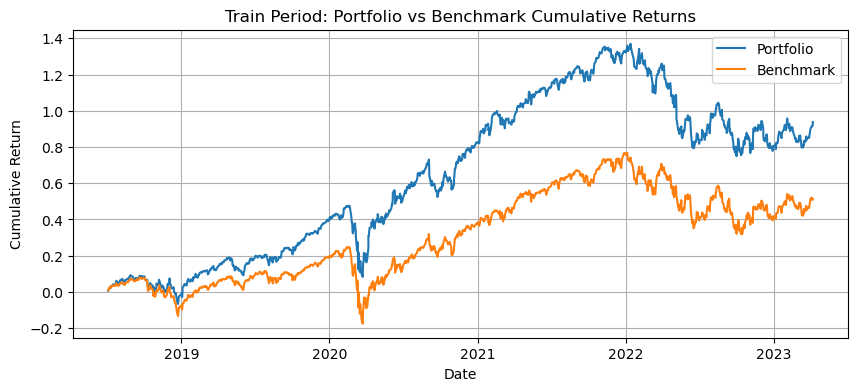

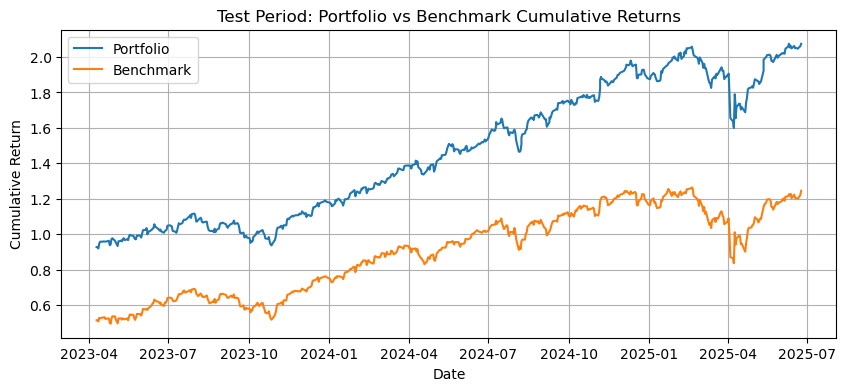

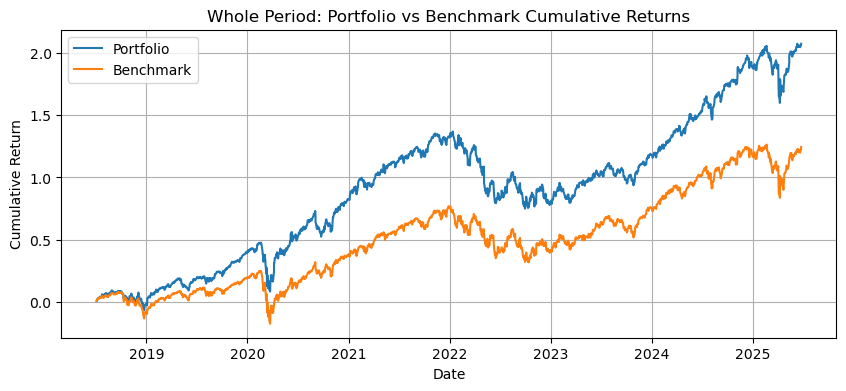

In [54]:
for name, data in periods.items():
    plt.figure(figsize=(10, 4))
    plt.plot(data["cum_p"].index, data["cum_p"], label = "Portfolio")
    plt.plot(data["cum_b"].index, data["cum_b"], label = "Benchmark")
    plt.title(f"{name} Period: Portfolio vs Benchmark Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

In [55]:
for name, data in periods.items():
    mp = compute_performance_metrics(data["ret_p"], risk_free_rate_daily, risk_free_rate_annual)
    mb = compute_performance_metrics(data["ret_b"], risk_free_rate_daily, risk_free_rate_annual)
    print(f"\n=== {name} Period Metrics ===")
    print("Portfolio Metrics:")
    for k, v in mp.items():
        print(f"  {k:22s}: {v:.4f}")
    print("Benchmark Metrics:")
    for k, v in mb.items():
        print(f"  {k:22s}: {v:.4f}")



=== Train Period Metrics ===
Portfolio Metrics:
  Cumulative Return     : 0.9377
  Annualized Return     : 0.1421
  Annualized Volatility : 0.1849
  Sharpe Ratio          : 0.7465
  Max Drawdown          : -0.2667
  VaR (95%)             : -0.0179
  CVaR (95%)            : -0.0274
Benchmark Metrics:
  Cumulative Return     : 0.5130
  Annualized Return     : 0.0910
  Annualized Volatility : 0.2211
  Sharpe Ratio          : 0.3935
  Max Drawdown          : -0.3392
  VaR (95%)             : -0.0208
  CVaR (95%)            : -0.0340

=== Test Period Metrics ===
Portfolio Metrics:
  Cumulative Return     : 0.5869
  Annualized Return     : 0.2222
  Annualized Volatility : 0.1248
  Sharpe Ratio          : 1.7477
  Max Drawdown          : -0.1501
  VaR (95%)             : -0.0116
  CVaR (95%)            : -0.0178
Benchmark Metrics:
  Cumulative Return     : 0.4841
  Annualized Return     : 0.1967
  Annualized Volatility : 0.1579
  Sharpe Ratio          : 1.2202
  Max Drawdown          : -0.18

## 9. Portfolio's alpha and beta relative to the benchmark

In [59]:
alpha_beta = {}

for name, data in periods.items():
    port_exc = data["ret_p"] - risk_free_rate_daily
    bench_exc = data["ret_b"] - risk_free_rate_daily

    df_excess = pd.concat([port_exc, bench_exc], axis = 1).dropna()
    df_excess.columns = ["portfolio_excess", "benchmark_excess"]

    X = df_excess[["benchmark_excess"]].values
    y = df_excess["portfolio_excess"].values

    if len(y) >= 2:
        model = LinearRegression().fit(X, y)
        alpha_d = model.intercept_
        beta    = model.coef_[0]
        alpha_a = (1 + alpha_d) ** 252 - 1
    else:
        alpha_d = beta = alpha_a = np.nan

    alpha_beta[name] = {
        "alpha_daily": alpha_d,
        "alpha_annual": alpha_a,
        "beta": beta
    }

# === Print results ===
for name, vals in alpha_beta.items():
    print(f"\n=== {name} Period Alpha & Beta ===")
    print(f"Daily Alpha      : {vals["alpha_daily"]:.6f}")
    print(f"Annual Alpha     : {vals["alpha_annual"]:.4f}")
    print(f"Beta             : {vals["beta"]:.4f}")


=== Train Period Alpha & Beta ===
Daily Alpha      : 0.000198
Annual Alpha     : 0.0513
Beta             : 0.8032

=== Test Period Alpha & Beta ===
Daily Alpha      : 0.000166
Annual Alpha     : 0.0428
Beta             : 0.7179

=== Whole Period Alpha & Beta ===
Daily Alpha      : 0.000174
Annual Alpha     : 0.0449
Beta             : 0.7867


## 10. Hypothesis Testing for Outperformance

We compute the daily difference between portfolio and benchmark, and perform a t-test on performance metrics

In [76]:
port_full  = result["portfolio_daily_returns_aligned"].dropna()
bench_full = result["benchmark_daily_returns_aligned"].dropna()

port_full  = port_full.loc[~port_full.index.duplicated()]
bench_full = bench_full.loc[~bench_full.index.duplicated()]
common     = port_full.index.intersection(bench_full.index)
port_full, bench_full = port_full.loc[common], bench_full.loc[common]

rebalance_dates = daily_returns.iloc[lookback::rebalance_period].index.tolist()
split_idx       = int(0.7 * len(rebalance_dates))
split_date      = rebalance_dates[split_idx - 1]

periods = {
    "Train": {"port": port_full[ port_full.index <= split_date],
              "bench": bench_full[ bench_full.index <= split_date]},
    "Test":  {"port": port_full[ port_full.index  > split_date],
              "bench": bench_full[ bench_full.index  > split_date]},
    "Whole": {"port": port_full, "bench": bench_full}
}

def windowed_t_tests(port_ser, bench_ser):
    samples = {f"{x}_{m}":[] for x in ("port","bench") for m in ("VaR","CVaR","MDD","Sharpe")}
    for d in rebalance_dates:
        if d not in port_ser.index: continue
        i = port_ser.index.get_loc(d)
        if i - lookback + 1 < 0: continue
        window = port_ser.index[i-lookback+1:i+1]
        pm = compute_performance_metrics(port_ser.loc[window], risk_free_rate_daily, risk_free_rate_annual)
        bm = compute_performance_metrics(bench_ser.loc[window], risk_free_rate_daily, risk_free_rate_annual)
        samples["port_VaR"].append(pm["VaR (95%)"])
        samples["bench_VaR"].append(bm["VaR (95%)"])
        samples["port_CVaR"].append(pm["CVaR (95%)"])
        samples["bench_CVaR"].append(bm["CVaR (95%)"])
        samples["port_MDD"].append(pm["Max Drawdown"])
        samples["bench_MDD"].append(bm["Max Drawdown"])
        samples["port_Sharpe"].append(pm["Sharpe Ratio"])
        samples["bench_Sharpe"].append(bm["Sharpe Ratio"])
    results = {}
    for label, metric in [("VaR","VaR (95%)"),("CVaR","CVaR (95%)"),
                          ("MDD","Max Drawdown"),("Sharpe","Sharpe Ratio")]:
        a = np.array(samples[f"port_{label}"])
        b = np.array(samples[f"bench_{label}"])
        n = min(len(a), len(b))
        a, b = a[:n], b[:n]
        mask = ~np.isnan(a) & ~np.isnan(b)
        a, b = a[mask], b[mask]
        if len(a) < 2:
            results[metric] = None
        else:
            t, p = stats.ttest_rel(a, b)
            results[metric] = {
                "port_mean": a.mean(),
                "bench_mean": b.mean(),
                "t_stat": t,
                "p_value": p,
                "significant": p < 0.05
            }
    return results

for name, grp in periods.items():
    print(f"\n=== {name} Period Hypothesis Tests ===")
    out = windowed_t_tests(grp["port"], grp["bench"])
    for metric, res in out.items():
        if res is None:
            print(f"{metric}:\n  not enough data\n")
        else:
            sig = "significant difference" if res["significant"] else "no significant difference"
            print(f"{metric}:")
            print(f"  Portfolio mean = {res['port_mean']:.4f}, Benchmark mean = {res['bench_mean']:.4f}")
            print(f"  t-statistic = {res['t_stat']:.4f}, p-value = {res['p_value']:.4f}")
            print(f"  => {sig}\n")


=== Train Period Hypothesis Tests ===
VaR (95%):
  Portfolio mean = -0.0172, Benchmark mean = -0.0213
  t-statistic = 9.1583, p-value = 0.0000
  => significant difference

CVaR (95%):
  Portfolio mean = -0.0246, Benchmark mean = -0.0300
  t-statistic = 11.2361, p-value = 0.0000
  => significant difference

Max Drawdown:
  Portfolio mean = -0.1099, Benchmark mean = -0.1361
  t-statistic = 7.5474, p-value = 0.0000
  => significant difference

Sharpe Ratio:
  Portfolio mean = 1.0387, Benchmark mean = 0.7959
  t-statistic = 5.0304, p-value = 0.0000
  => significant difference


=== Test Period Hypothesis Tests ===
VaR (95%):
  Portfolio mean = -0.0113, Benchmark mean = -0.0143
  t-statistic = 6.3020, p-value = 0.0000
  => significant difference

CVaR (95%):
  Portfolio mean = -0.0162, Benchmark mean = -0.0194
  t-statistic = 5.6387, p-value = 0.0000
  => significant difference

Max Drawdown:
  Portfolio mean = -0.0757, Benchmark mean = -0.0951
  t-statistic = 9.2030, p-value = 0.0000
  =>

## 11. Sensitivity Analysis with Monte Carlo Simulation

What is parameter sensitivity analysis ? Instead of evaluating our strategy at just a fixed value of $\tau$, $\delta$, or other varaibles, we can simulate many scenarios in which these parameters vary randomly within realistic ranges. This also helps us understand the stability of our model.

Here we test our model with different values of $\tau$.

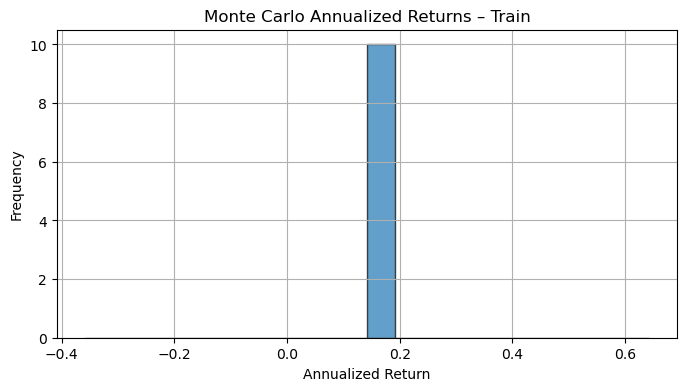


=== Train Period ===
Mean Annualized Return: 0.1421
Std. Dev. of Annualized Return: 0.0000
Min Annualized Return: 0.1421
Max Annualized Return: 0.1421


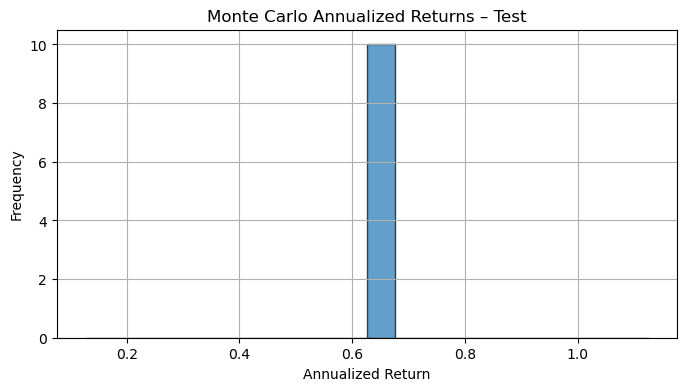


=== Test Period ===
Mean Annualized Return: 0.6264
Std. Dev. of Annualized Return: 0.0000
Min Annualized Return: 0.6264
Max Annualized Return: 0.6264


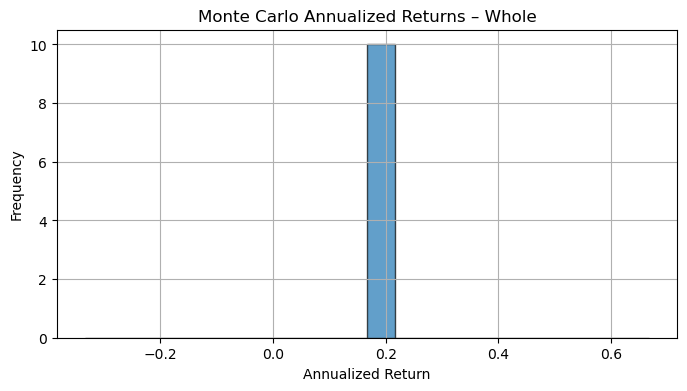


=== Whole Period ===
Mean Annualized Return: 0.1668
Std. Dev. of Annualized Return: 0.0000
Min Annualized Return: 0.1668
Max Annualized Return: 0.1668


In [74]:
n_simulations = 10
tau_samples   = np.random.uniform(0.015, 0.035, n_simulations)

rebalance_dates = daily_returns.iloc[lookback::rebalance_period].index.tolist()
split_idx       = int(len(rebalance_dates) * 0.7)
split_date      = rebalance_dates[split_idx - 1]

annualized = {"Train": [], "Test": [], "Whole": []}

for tau in tau_samples:
    result = Monte_Carlo_simulate(tau)
    pcum = result["portfolio_cum_returns"]
    
    pcum_train = pcum.loc[:split_date]
    n_train    = len(pcum_train)
    final_train = pcum_train.iloc[-1]
    ann_train  = (1 + final_train) ** (252 / n_train) - 1
    annualized["Train"].append(ann_train)
    
    pcum_test  = pcum.loc[split_date:]
    n_test     = len(pcum_test)
    final_test = pcum_test.iloc[-1]
    ann_test   = (1 + final_test) ** (252 / n_test) - 1
    annualized["Test"].append(ann_test)
    
    n_whole    = len(pcum)
    final_whole = pcum.iloc[-1]
    ann_whole  = (1 + final_whole) ** (252 / n_whole) - 1
    annualized["Whole"].append(ann_whole)

for period in annualized:
    annualized[period] = np.array(annualized[period])

for period, arr in annualized.items():
    plt.figure(figsize = (8, 4))
    plt.hist(arr, bins = 20, edgecolor = "k", alpha = 0.7)
    plt.title(f"Monte Carlo Annualized Returns – {period}")
    plt.xlabel("Annualized Return")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
    
    print(f"\n=== {period} Period ===")
    print(f"Mean Annualized Return: {arr.mean():.4f}")
    print(f"Std. Dev. of Annualized Return: {arr.std():.4f}")
    print(f"Min Annualized Return: {arr.min():.4f}")
    print(f"Max Annualized Return: {arr.max():.4f}")

Here we test our model different view vector Q

We inject a zero-mean Gaussian noise term ε into Q, where εᵢ ~ N(0, Ωᵢᵢ).
In the Black–Litterman framework, Ω is the diagonal matrix of view uncertainties,
so sampling noise with variance Ωᵢᵢ explores plausible errors around each view.

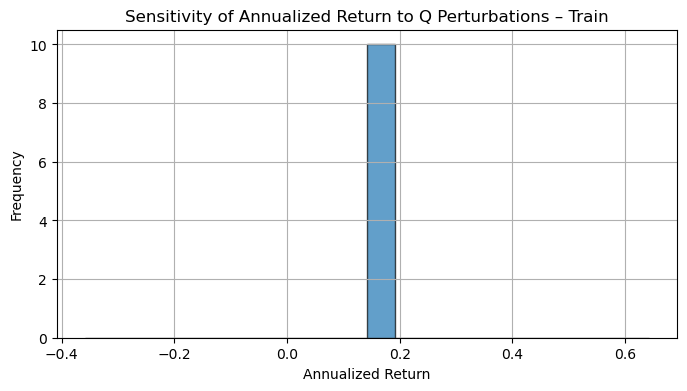


=== Train Period Q-Perturbation Summary ===
Mean Annualized Return: 0.1421
Std. Dev. of Annualized Return: 0.0000
Min Annualized Return: 0.1421
Max Annualized Return: 0.1421


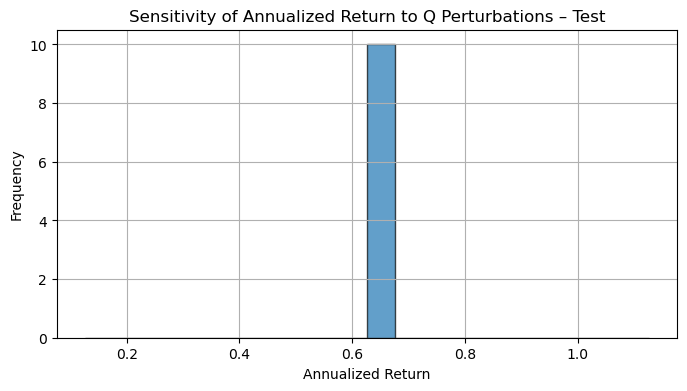


=== Test Period Q-Perturbation Summary ===
Mean Annualized Return: 0.6264
Std. Dev. of Annualized Return: 0.0000
Min Annualized Return: 0.6264
Max Annualized Return: 0.6264


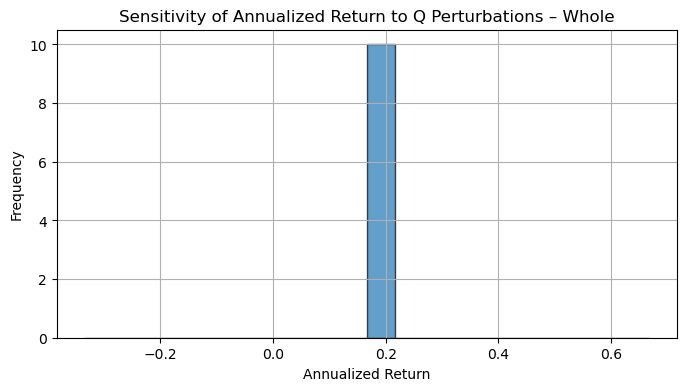


=== Whole Period Q-Perturbation Summary ===
Mean Annualized Return: 0.1668
Std. Dev. of Annualized Return: 0.0000
Min Annualized Return: 0.1668
Max Annualized Return: 0.1668


In [75]:
n_Q_sims = 10
tau0     = 0.025

rebalance_dates = daily_returns.iloc[lookback::rebalance_period].index.tolist()
split_idx       = int(len(rebalance_dates) * 0.7)
split_date      = rebalance_dates[split_idx - 1]

annualized_Q = {
    "Train": [],
    "Test":  [],
    "Whole": []
}

for i in range(n_Q_sims):
    # turn on perturbation
    PERTURB_Q = True

    result = Monte_Carlo_simulate(tau0)
    pcum   = result["portfolio_cum_returns"]

    pcum_train = pcum.loc[:split_date]
    n_train    = len(pcum_train)
    final_t    = pcum_train.iloc[-1]
    ann_train  = (1 + final_t) ** (252 / n_train) - 1
    annualized_Q["Train"].append(ann_train)

    pcum_test  = pcum.loc[split_date:]
    n_test     = len(pcum_test)
    final_s    = pcum_test.iloc[-1]
    ann_test   = (1 + final_s) ** (252 / n_test) - 1
    annualized_Q["Test"].append(ann_test)

    n_whole    = len(pcum)
    final_w    = pcum.iloc[-1]
    ann_whole  = (1 + final_w) ** (252 / n_whole) - 1
    annualized_Q["Whole"].append(ann_whole)

    # turn off perturbation
    PERTURB_Q = False

for period in annualized_Q:
    annualized_Q[period] = np.array(annualized_Q[period])

for period, arr in annualized_Q.items():
    plt.figure(figsize = (8, 4))
    plt.hist(arr, bins = 20, edgecolor = "k", alpha = 0.7)
    plt.title(f"Sensitivity of Annualized Return to Q Perturbations – {period}")
    plt.xlabel("Annualized Return")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    print(f"\n=== {period} Period Q-Perturbation Summary ===")
    print(f"Mean Annualized Return: {arr.mean():.4f}")
    print(f"Std. Dev. of Annualized Return: {arr.std():.4f}")
    print(f"Min Annualized Return: {arr.min():.4f}")
    print(f"Max Annualized Return: {arr.max():.4f}")